In [288]:
import torchvision
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
from random import sample
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torchvision.utils import save_image


from torchvision.datasets import CIFAR10

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The codes for creating train and test is inspired from here:
https://medium.com/@sergioalves94/deep-learning-in-pytorch-with-cifar-10-dataset-858b504a6b54

In [3]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
# test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified


In [4]:
classes = dataset.classes

print('Classes in dataset: ', classes)

Classes in dataset:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
class_count = {}
for _, index in dataset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1

print('Class count :', class_count)

Class count : {'frog': 5000, 'truck': 5000, 'deer': 5000, 'automobile': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'airplane': 5000}


In [299]:
class PrepareData(Dataset):
    def __init__(self, X, y,):
        super(PrepareData, self).__init__()
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

def create_train_val(train_data, label_data, 
                     percentage=0.2, batchsize=64,
                     x_dim=20, just_split=None, 
                     options=None, test_per=None
                    ):
    index = np.arange(train_data.shape[0])
    
    if test_per == None:
        split = int(train_data.shape[0] * percentage)
    
    np.random.shuffle(index)
    
    if just_split == True:
        #val index, train
        
        return index[:split], index[split:]
    
    val_dataset = PrepareData(train_data[index[:split]], 
                              label_data[index[:split]],
                             )
    val_dataloader = DataLoader(dataset=val_dataset, 
                        shuffle=False, 
                        batch_size=batchsize)
    
    if just_split == 'include_val':
        if test_per is not None:
            test = len(index[split:]) * test_per
            
            test_dataset = PrepareData(train_data[index[split : split + test]],
                                      label_data[index[split : split + test]],
                                     )
            test_dataloader = DataLoader(dataset=test_dataset, 
                                shuffle=False, 
                                batch_size=batchsize)
            
            return val_dataloader, test_dataloader
            
        return val_dataloader, index[split:]
    

    train_dataset = PrepareData(train_data[index[split:]], 
                                label_data[index[split:]],
                               )
   
    train_dataloader = DataLoader(dataset=train_dataset, 
                              shuffle=False, 
                              batch_size=batchsize)
        
    
    return train_dataloader, val_dataloader


def split_data(train_data, train_percentage, 
               test_percentage):
    index = np.arange(train_data.shape[0])
    np.random.shuffle(index)
    
    if test_percentage == None:
        split = int(train_data.shape[0] * train_percentage)
        
        #val, train
        return index[:split], index[split:]
    
    
    if test_percentage is not None:
        split = int(train_data.shape[0] * train_percentage)
        
        test = int(len(index[split:]) * test_percentage)
        
        #train, test
        return index[:split], index[split : split + test]

def create_dataloader(x, y, batchsize):
    data = PrepareData(x, y)
   
    return DataLoader(dataset=data, shuffle=False, 
                      batch_size=batchsize)

def normalize(data):
    return data / 255


def rescale(data):
    return (data * 2 / 255) - 1  

def brighten_pixel(data, percent = 10):
    illumination = ((100 + percent) / 100)
    
    return torch.min(data * illumination, 
                     torch.ones(data.shape))

def darken_pixel(data, percent = 10):
    illumination = (100 - percent) / 100
    
    return data * illumination

def flip_image(data):
    data = torchvision.transforms.functional.hflip(data)
     
    return data #.view(data.shape[0], -1)

def reshape_image(dataset, option=None):
    new_x_tensor = []
    new_y_tensor = []
    
    for x, y in dataset:
        #Normalization already done automatically by pytorch
#         x = normalize(x)

        y = torch.tensor(y, dtype=torch.long)
            
        new_x_tensor.append(x)
        new_y_tensor.append(y)
        
    new_x_tensor = torch.stack(new_x_tensor)
    new_y_tensor = torch.stack(new_y_tensor)
    shape_0 = new_x_tensor.shape[0]
    
    print(new_x_tensor.shape)
    
    return new_x_tensor, new_y_tensor


def tensor_from_index(index, X, Y):
    new_x_tensor = []
    new_y_tensor = []
    
    for i in index:
        y = torch.tensor(Y[i], dtype=torch.long)
            
        new_x_tensor.append(X[i])
        new_y_tensor.append(y)
        
    new_x_tensor = torch.stack(new_x_tensor)
    new_y_tensor = torch.stack(new_y_tensor)
    
    return new_x_tensor, new_y_tensor

def rotate_image_90(data):
    return torchvision.transforms.functional.rotate(data, 90)

def flip_image_vertically(data):
    return torchvision.transforms.functional.hflip(data)
    

def transformation(index, X):
    new_x_tensor = []
    new_y_tensor = []
    i = 0
    sample = 5
    
    sample_img = {
        'flip_vertical_2': [],
        'rotate_2': [],
        'original_2': [],
    }
    
    for index_i, j in enumerate(index):
        new_x_tensor.append(X[j])
        new_y_tensor.append(torch.tensor(i, dtype=torch.long))
        
        
        x_flip = flip_image_vertically(X[j])
        
        new_x_tensor.append(x_flip)
        new_y_tensor.append(
            torch.tensor(i + 1, dtype=torch.long))
        
        x_90 = rotate_image_90(X[j])
        
        new_x_tensor.append(x_90)
        new_y_tensor.append(
            torch.tensor(i + 2, dtype=torch.long))
        
        if index_i < sample:
            sample_img['original_2'].append(X[j])
            sample_img['flip_vertical_2'].append(x_flip)
            sample_img['rotate_2'].append(x_90)
        
    
    new_x_tensor = torch.stack(new_x_tensor)
    new_y_tensor = torch.stack(new_y_tensor)
    
    return new_x_tensor, new_y_tensor, sample_img
        
        
def augment_data(index, X, Y):
    brighten = []
    darken = []
    flipped = []
    new_x_tensor = []
    new_y_tensor = []
    sample = 5
    sample_img = {
        'original': [],
        'brighten': [],
        'darken': [],
        'flip': []
    }
    
    for index_i, i in enumerate(index):
        x_brighten = brighten_pixel(X[i])
        
        y = Y[i]
        
        new_x_tensor.append(x_brighten)
        new_y_tensor.append(y)

        x_darken = darken_pixel(X[i])
        
        new_x_tensor.append(x_darken)
        new_y_tensor.append(y)

        x_flip = flip_image(X[i])
        
        new_x_tensor.append(x_flip)
        new_y_tensor.append(y)
        
        new_x_tensor.append(X[i])
        new_y_tensor.append(y)
        
        if index_i < sample:
            sample_img['brighten'].append(x_brighten)
            sample_img['darken'].append(x_darken)
            sample_img['flip'].append(x_flip)
            sample_img['original'].append(X[i])
        

    new_x_tensor = torch.stack(new_x_tensor)
    new_y_tensor = torch.stack(new_y_tensor)
    
    print(new_x_tensor.shape, new_y_tensor.shape)
    
    return new_x_tensor, new_y_tensor, sample_img


class CNN(nn.Module):
    def __init__(self, parameters):
        super(CNN, self).__init__()
        self.type_init = parameters['type_init']
        self.activation = parameters['activation']
        self.dropout = parameters['dropout']
        
        
        self.conv1 = nn.Conv2d(in_channels=parameters['in_channel'],
                               out_channels=parameters['out_channel'],
                               kernel_size=parameters['kernel_size'],
                               stride=parameters['stride'],
                               )
        self.max1 = nn.MaxPool2d(kernel_size=parameters['pool_kernel_size'],
                                 stride=parameters['pool_stride']
                                )
        
        self.conv2 = nn.Conv2d(in_channels=parameters['2nd_in_channel'],
                               out_channels=parameters['2nd_out_channel'],
                               kernel_size=parameters['2nd_kernel_size'],
                               stride=parameters['stride'])
        self.max2 = nn.MaxPool2d(kernel_size=parameters['pool_kernel_size'],
                                 stride=parameters['pool_stride'])
        self.flatten = nn.Flatten()
        self.l4 = nn.Linear(parameters['in_dim'], parameters['out_dim'])
        self.l5 = nn.Linear(parameters['out_dim'], parameters['softmax_dim'])
#         self.l3 = nn.Softmax(dim=1)
        
        if self.type_init in ['He']:
            for key, layer in self.named_children():
                if key in ['max1', 'max2', 'flatten', 'l3']:
                    continue
                    
                nn.init.kaiming_uniform_(layer.weight)



    def forward(self, x):
        for key, layer in self.named_children():
            if layer in ['conv1', 'conv2', 'flatten', 'l3']:
                continue
            if self.activation == 'sigmoid':
                printk(key)
                x = F.sigmoid(layer(x))
            if self.activation == 'ReLU':
                x = F.relu(layer(x))

        return x
    
    
    
def calc_loss(dataloader, loss_fn, model):
    total_loss = 0
    
    model.eval()
    
    size = len(dataloader.dataset)
    batch_size = len(dataloader)
    m = nn.Softmax(dim=1)
    with torch.no_grad():
        total_loss, correct = 0, 0
        
        for X, y in dataloader:            
            X, y = X.to(device), y.to(device)
            
            pred = model(X).to(device)
            pred = m(pred)

            total_loss += loss_fn(pred, y).item()
            pred_y = pred.argmax(1)
            correct += (pred_y == y).type(torch.float).sum().item()
        
    total_loss /= batch_size
    correct /= size
    
    return [total_loss, correct]


def train(model, dataloader, val_dataloader, 
          loss_fn, optimizer, validate=True):
    model.train()
    train_loss, correct = 0, 0
    m = nn.Softmax(dim=1)
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss = train_loss + loss.item()
#         print('X :', X.shape)
#         print('y :', y.shape)
#         print('pred :', pred.shape)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if validate == True:
        loss_accuracy = calc_loss(val_dataloader, loss_fn, model)
 
        return loss_accuracy

    train_loss /= num_batches
    
    return train_loss


# def transfer_learning(parameters):
    
    
def process(parameters, option = None):
    if option == 'augmented':
        new_x, new_y = reshape_image(parameters['dataset'],
                                 option
                                )
        
        val_dataloader, index = create_train_val(new_x, new_y, parameters['split'],
                                parameters['batch'], x_dim=20, 
                                just_split='include_val', options=True)
        new_x_tensor, new_y_tensor, sample_img = augment_data(index, 
                                                              new_x, new_y)
        
#         plot_image(sample_img)
        
        train_dataloader = create_dataloader(new_x_tensor, new_y_tensor,
                                             parameters['batch']
                                            )
        print(len(val_dataloader.dataset))
        print(len(train_dataloader.dataset))
        
        filename = 'hw3_qns1_augm_loss.pkl.gz'
        
    
    if option == None:
        new_x, new_y = reshape_image(parameters['dataset'],
                                 option
                                )
        train_dataloader, val_dataloader = create_train_val(new_x, new_y,
                                                   parameters['split'],
                                                   parameters['batch']
                                                   )
        filename = 'hw3_qns1_loss.pkl.gz'
        
    if option == 'pretext':
        new_x, new_y = reshape_image(parameters['dataset'],
                                 option
                                )
        val_dataloader, index = create_train_val(new_x, new_y, 
                                                 parameters['split'],
                                                 parameters['batch'], x_dim=20, 
                                                 just_split='include_val', 
                                                 options=True)
        new_x_tensor, new_y_tensor, sample_img = transformation(index, new_x)
        
        train_dataloader = create_dataloader(new_x_tensor, new_y_tensor,
                                             parameters['batch']
                                            )

#         plot_image(sample_img)

        filename = 'hw3_qns2_loss.pkl.gz'
        
        print(len(val_dataloader.dataset))
        print(len(train_dataloader.dataset))
        
    if (option == 'baseline') or (option == 'transfer_learning'):
        new_x, new_y = reshape_image(parameters['dataset'],
                                 option
                                )
        train_index, test_index = split_data(new_x, 
                                             parameters['train_per'],
                                             parameters['test_per'])
        new_x_tensor, new_y_tensor = tensor_from_index(train_index, 
                                                       new_x, new_y)
        train_dataloader = create_dataloader(new_x_tensor, 
                                             new_y_tensor,
                                             parameters['batch']
                                            )
        new_x_tensor, new_y_tensor = tensor_from_index(test_index, 
                                                       new_x, new_y)
        
        val_dataloader = create_dataloader(new_x_tensor, 
                                            new_y_tensor,
                                            parameters['batch']
                                            )
        
        print(len(val_dataloader.dataset))
        print(len(train_dataloader.dataset))
        
        filename = 'hw3_qns2_baseline_loss.pkl.gz'
        
        
    print('\n --------------- Model creation : start -------- \n')
        
    model = CNN(parameters['conv2d']).to(device)
    
    if option == 'transfer_learning':
        model_name = 'hw_3_pretext.model'
        filename = 'hw3_qns2_transfer_learning_loss.pkl.gz'
        
        model.load_state_dict(torch.load(model_name))
        
    
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer_adam = torch.optim.Adam(model.parameters(), 
                                      lr=parameters['lr_rate'])
    
    print('\n --------------- Training : start -------- \n')

    #train_loss, validation accuracy
    all_loss = []
    for t in range(parameters['epoch']):
        loss = train(model, train_dataloader, 
                     val_dataloader, loss_fn, 
                     optimizer_adam, 
                     validate=parameters['validate'])
       
        
       
        if (t % 100 == 0):
            print('Epoch :', t)
            
            all_loss.append(loss)
            
            if parameters['validate'] == True:
                print('Train loss : ', loss[0])
                print('Val Accuracy : ', loss[1])
            else:
                print('Train loss : ', loss)
    
    if parameters['validate'] == True:
        (pd.DataFrame(data=all_loss, 
                      columns=['train_loss','val_accuracy'])
         .to_pickle(filename)
        )
        
    if parameters['validate'] == False:
        (pd.DataFrame(data=all_loss, 
                      columns=['train_loss'])
         .to_pickle(filename)
        )
    
    torch.save(model.state_dict(), f'./hw_3_{option}.model')
    
def plot_image(sample_img):
    for keys in sample_img:
        i = 0
        for image in sample_img[keys]:
            print(keys + f'_{i}')
            
            new_image = image.permute(1, 2, 0)
            
            plt.imshow(new_image)
            
            plt.savefig(f'{keys}_{i}.png')
            i = i + 1


parameters = {
    'dataset': dataset,
    'val_size': 5000,
    'split': 0.01,
    'train_per': 0.01,
    'test_per': 0.21,
    'batch': 64,
    "in_dim": 250,
    "out_dim": 20,
    'softmax': 3,
    "batchsize": 64,
    "dropout": None,
    "activation": "ReLU",
    "type_init": "xavier",
    "lr_rate": 0.001,
    "epoch": 10000,
    'validate': True,
    "kernel_size":10,
     "conv2d":{
        "in_channel": 3,
        "out_channel": 10,
        "kernel_size":(5, 5),
        "stride": (1, 1),
        "activation": "ReLU",
        "type_init": "He",
        "pool_kernel_size": (2,2),
        "pool_stride": (2, 2),
        "in_dim": 250,
        "out_dim": 20,
        "softmax_dim": 10,
        "dropout": None,
        "2nd_kernel_size": (5,5),
        "2nd_in_channel": 10,
        "2nd_out_channel":10
    },
    
}

# process(parameters)
# process(parameters, 'augmented')
# process(parameters, 'pretext')
# process(parameters, 'baseline')
# process(parameters, 'transfer_learning')

In [310]:
def plot_fig(x, y, title, fig_name, second_data=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.plot(x, y, label='Baseline', color='blue')
    
    if second_data is not None:
        ax.plot(second_data['x'], second_data['y'], 
                color='red', label=second_data['label'])
        
    ax.title.set_text(title)

    ax.legend(loc="lower right")
    ax.set_xlabel('epochs')
    ax.set_ylabel('Validation Accuracy in fraction')

    fig.savefig(f'{fig_name}', facecolor='white', 
                transparent=False)

    plt.show()

In [306]:
import matplotlib.image as mpimg

def plot_multiple_images(images, column, row, fig_name):
    j = 0
    k = 0

    fig, ax = plt.subplots(row, column, figsize=(22, 14), sharex=True)

    for i, image in enumerate(images):
        if k == row:
            break

        new_ax = ax[k, j]
        
        img = mpimg.imread(image)
        plt.imshow(img)
        
        new_ax.imshow(img)

        if j == (column - 1):
            j = 0
            k = k + 1

        else:
            j = j + 1

    fig.savefig(f'{fig_name}', facecolor='white', 
                transparent=False)

    plt.show()

### Answers



----Problem 1  -------------------- 

   index  train_loss  val_accuracy
0     87    1.892453        0.6386
1     85    1.893034        0.6376
2     92    1.888999        0.6368
3     95    1.889865        0.6362
4     83    1.893061        0.6360


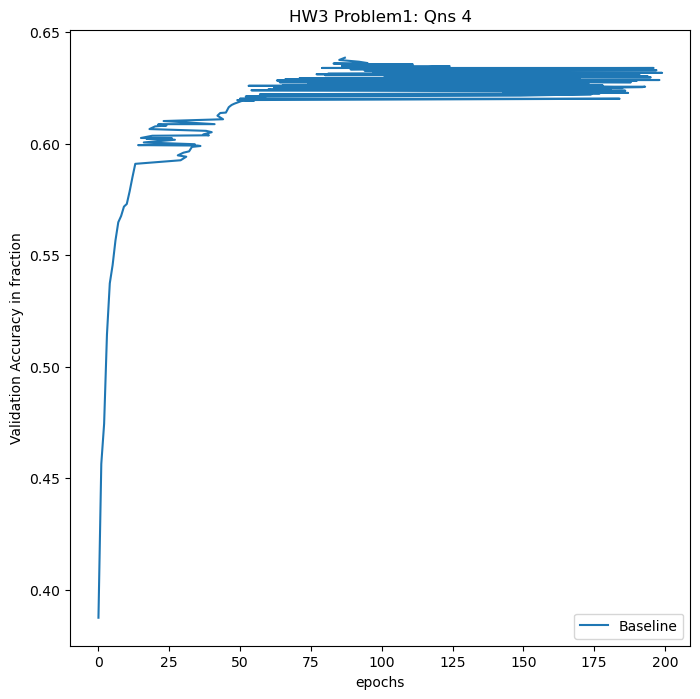



---- Problem 1, Qns 5 Augmentation -------------------- 

   index  train_loss  val_accuracy
0    189    1.930902         0.598
1    172    1.932199         0.598
2    184    1.930815         0.598
3    186    1.930403         0.598
4    159    1.933807         0.598


 ------ Augmentation accuracy ------ 



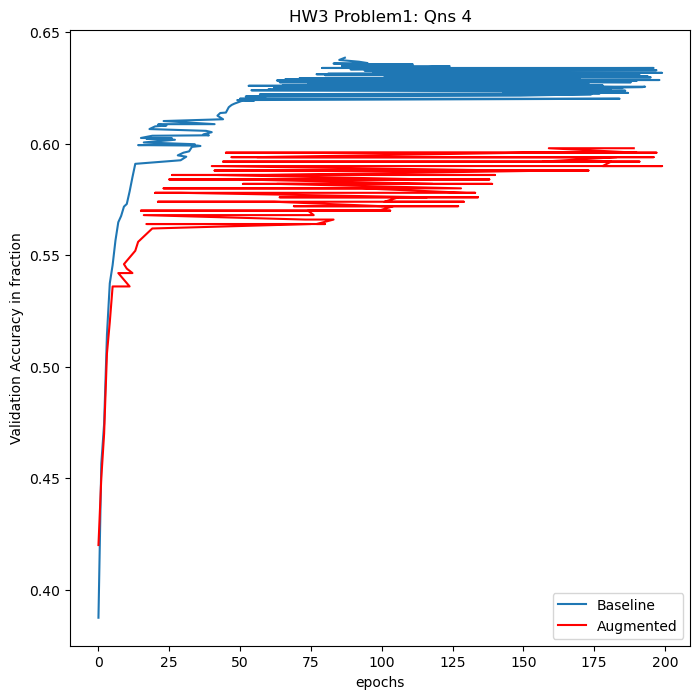

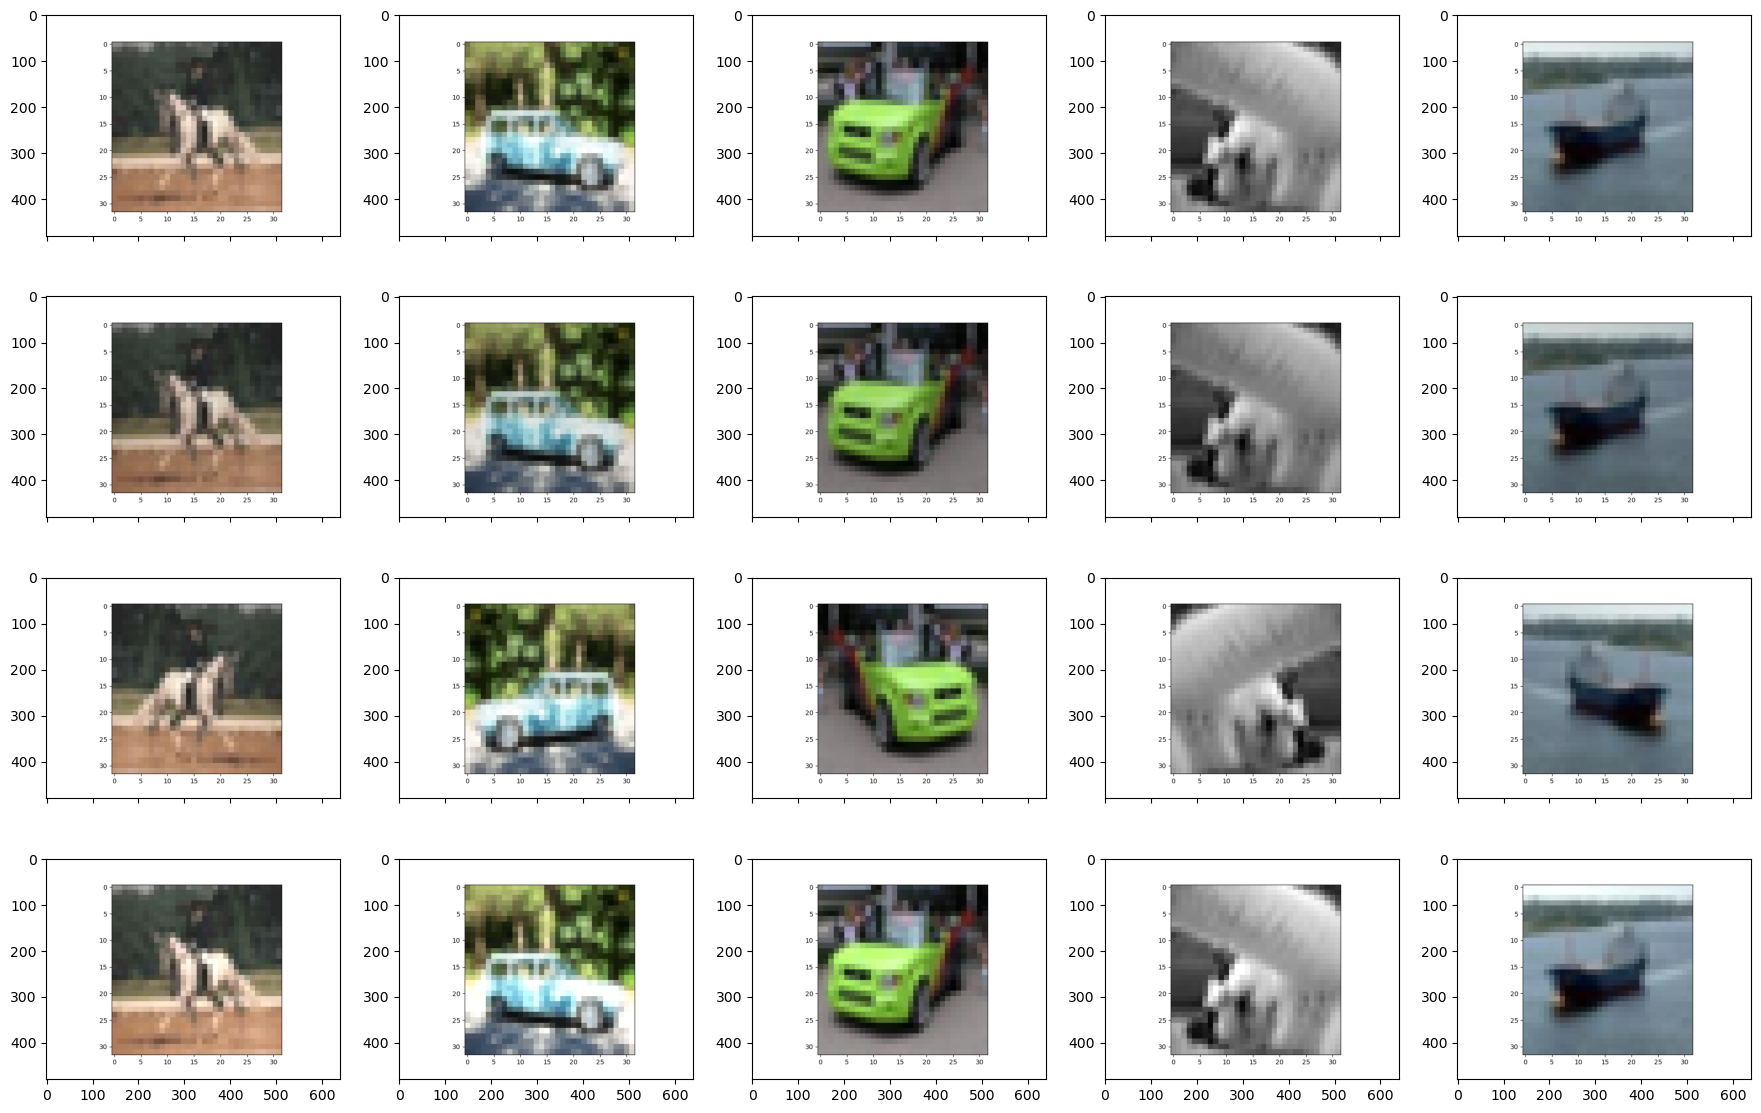


-------- Rotation and Vertical Flip --------- 


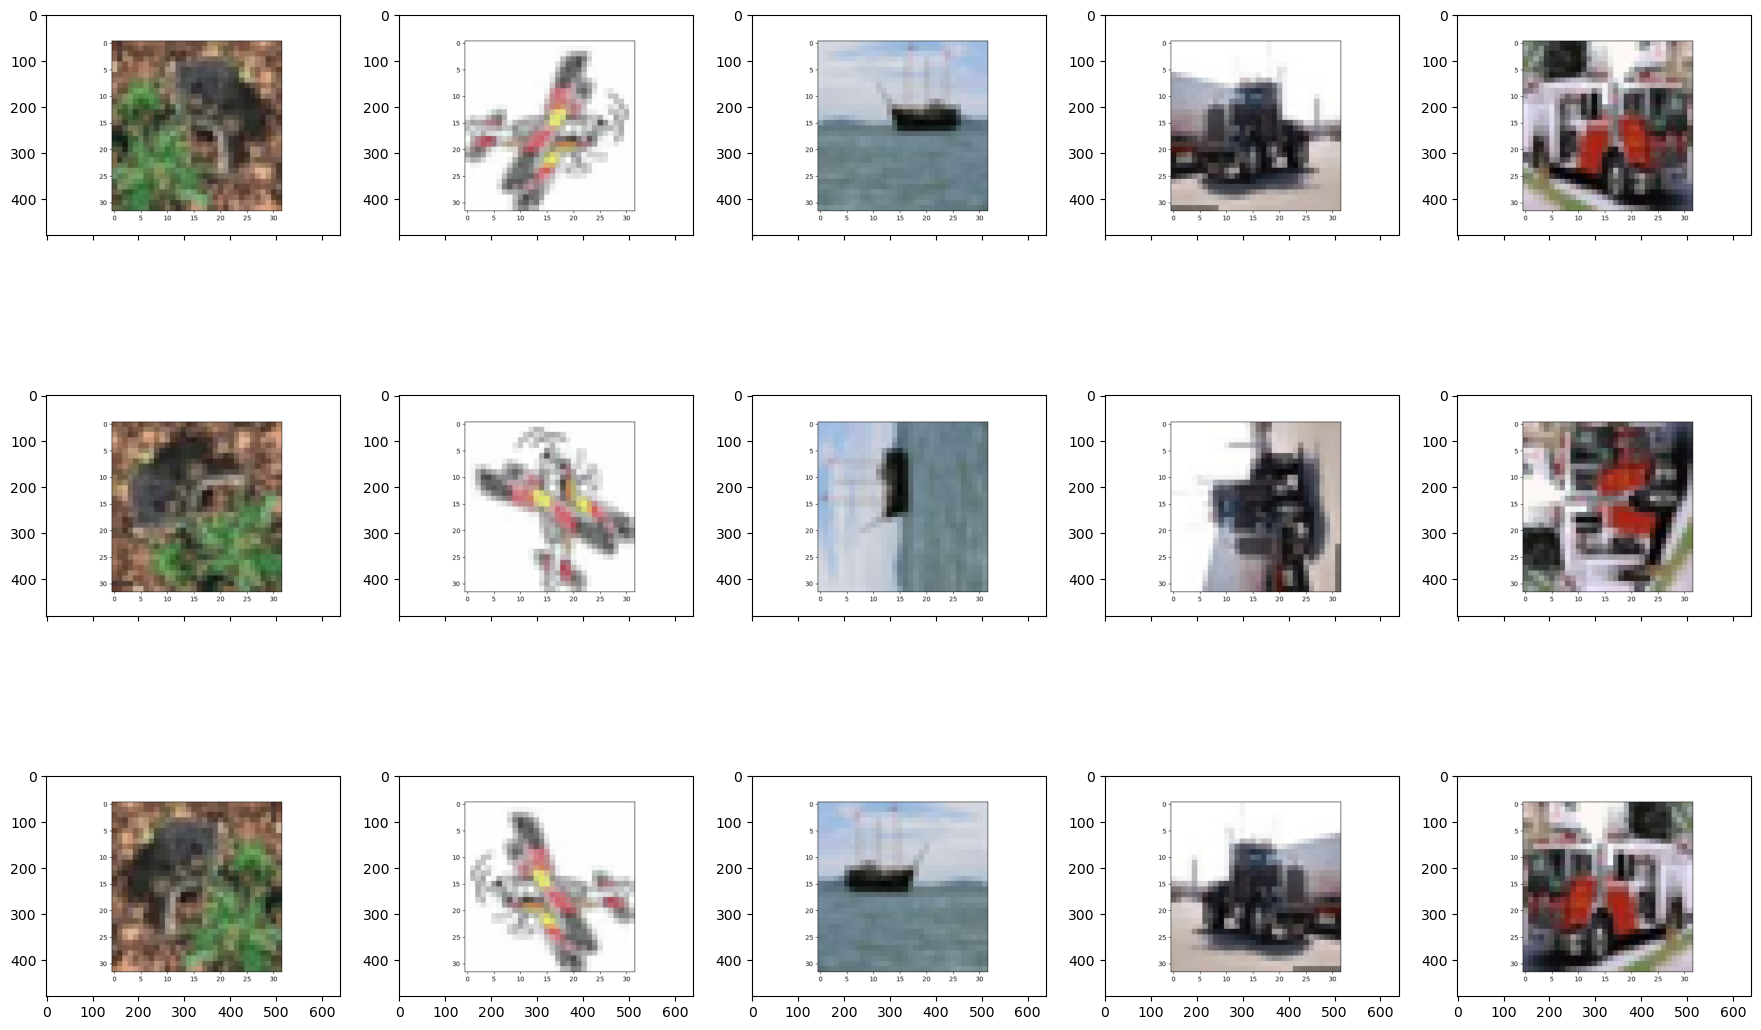



---- Problem 2: Qns 2 -------------------- 

   train_loss
0    0.963326
1    0.884200
2    0.857030
3    0.840228
4    0.826036


 ---------- Problem 2: Qns 3, 4, 5 ---------- 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 25 to 0
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         100 non-null    int64  
 1   train_loss    100 non-null    float64
 2   val_accuracy  100 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.1 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 57 to 0
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         100 non-null    int64  
 1   train_loss    100 non-null    float64
 2   val_accuracy  100 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.1 KB
None


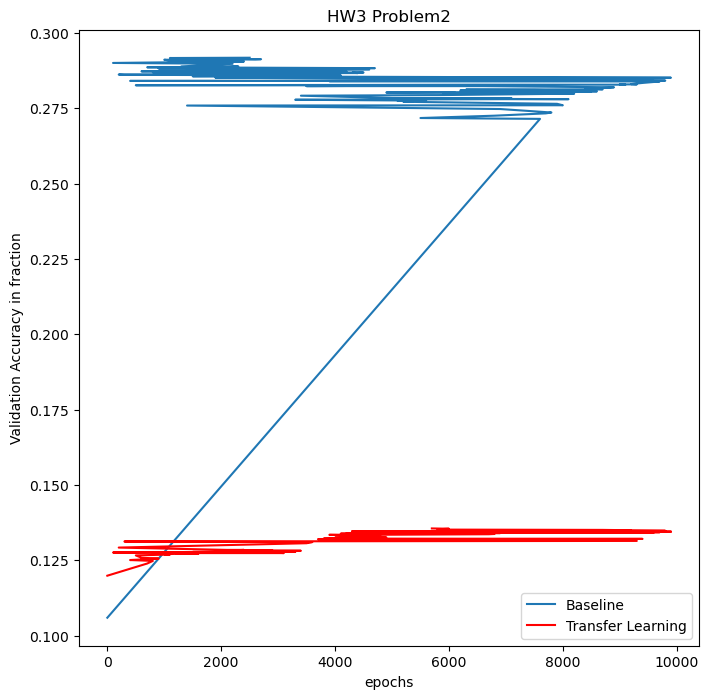

In [318]:
print('\n\n----Problem 1  -------------------- \n')

df = pd.read_pickle('hw3_qns1_loss.pkl.gz')
df = df.sort_values(by=['val_accuracy'], ascending =False)

df.reset_index(inplace=True)

print(df.head())

plot_fig(df['index'], df['val_accuracy'],
         'HW3 Problem1: Qns 4', 
         'hw3_prob_1_qn4.png'
        )

print('\n\n---- Problem 1, Qns 5 Augmentation -------------------- \n')

df_aug = pd.read_pickle('hw3_qns1_augm_loss.pkl.gz')
df_aug = df_aug.sort_values(by=['val_accuracy'], 
                        ascending =False)


df_aug.reset_index(inplace=True)

print(df_aug.head())

print('\n\n ------ Augmentation accuracy ------ \n')

second_data = {}
second_data['x'] = df_aug['index']
second_data['y'] = df_aug['val_accuracy']
second_data['label'] = 'Augmented'

plot_fig(df['index'], df['val_accuracy'],
         'HW3 Problem1: Qns 4', 
         'hw3_prob_1_qn567.png',
         second_data
        )

images = []
for  x in ['original', 'darken', 
                    'flip', 'brighten']:
    for i in range(5):
        images.append(f'{x}_{i}.png')

plot_multiple_images(images, 5, 4, 'hw3_prob_1_qns5.png')

print('\n-------- Rotation and Vertical Flip --------- ')
images = []
for  x in ['original_2', 'rotate_2', 'flip_vertical_2']:
    for i in range(5):
        images.append(f'{x}_{i}.png')

plot_multiple_images(images, 5, 3, 'hw3_prob_2_qns2.png')


print('\n\n---- Problem 2: Qns 2 -------------------- \n')

df = pd.read_pickle('hw3_qns2_loss.pkl.gz')

print(df.head())


print('\n\n ---------- Problem 2: Qns 3, 4, 5 ---------- \n')

df_base = pd.read_pickle('hw3_qns2_baseline_loss.pkl.gz')
df_base.reset_index(inplace=True)

df_base['index'] = df_base['index'].apply(
    lambda x: x * 100)

df_base = df_base.sort_values(by=['val_accuracy'], 
                              ascending =False)
print(df_base.info())



df_trans = pd.read_pickle('hw3_qns2_transfer_learning_loss.pkl.gz')
df_trans.reset_index(inplace=True)

df_trans['index'] = df_trans['index'].apply(
    lambda x: x * 100)

df_trans = df_trans.sort_values(by=['val_accuracy'], 
                                ascending =False)
print(df_trans.info())


second_data = {}
second_data['x'] = df_trans['index']
second_data['y'] = df_trans['val_accuracy']
second_data['label'] = 'Transfer Learning'

plot_fig(df_base['index'], df_base['val_accuracy'],
         'HW3 Problem2', 
         'hw3_prob_2_transfer.png',
         second_data
        )